# Bike City Share

We will work on the data posted on the site [NYC and Bike City Share, LCC and Jersey City Share, LCC](https://www.citibikenyc.com/system-data). The data shall include details of urban bike rentals (start and end date, destination, geographical data, etc.).

## Preparation
Let's first download the data corresponding to one month (the most recent)

In [34]:
import pandas as pd
import zipfile
import os


data_folder = 'data'
data_file_sample = '201910-citibike-tripdata'
data_path = os.path.join(os.getcwd(), data_folder, data_file_sample+'.csv.zip')
zf = zipfile.ZipFile(data_path)
data_sample = pd.read_csv(zf.open(data_file_sample+'.csv'), parse_dates=['starttime', 'stoptime'])

## A glance at the data
Let's check at the beginning what the general data structure looks like

In [35]:
data_sample.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,527,2019-10-01 00:00:05.618,2019-10-01 00:08:52.943,3746,6 Ave & Broome St,40.724308,-74.004730,223,W 13 St & 7 Ave,40.737815,-73.999947,41750,Subscriber,1993,1
1,174,2019-10-01 00:00:15.875,2019-10-01 00:03:10.168,3301,Columbus Ave & W 95 St,40.791956,-73.968087,3283,W 89 St & Columbus Ave,40.788221,-73.970416,18264,Subscriber,1992,1
2,759,2019-10-01 00:00:19.824,2019-10-01 00:12:59.707,161,LaGuardia Pl & W 3 St,40.729170,-73.998102,174,E 25 St & 1 Ave,40.738177,-73.977387,25525,Subscriber,1995,1
3,615,2019-10-01 00:00:21.068,2019-10-01 00:10:36.679,254,W 11 St & 6 Ave,40.735324,-73.998004,477,W 41 St & 8 Ave,40.756405,-73.990026,30186,Subscriber,1992,1
4,761,2019-10-01 00:00:26.380,2019-10-01 00:13:08.313,161,LaGuardia Pl & W 3 St,40.729170,-73.998102,174,E 25 St & 1 Ave,40.738177,-73.977387,25597,Subscriber,1992,1


In [36]:
data_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2092573 entries, 0 to 2092572
Data columns (total 15 columns):
tripduration               int64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start station id           int64
start station name         object
start station latitude     float64
start station longitude    float64
end station id             int64
end station name           object
end station latitude       float64
end station longitude      float64
bikeid                     int64
usertype                   object
birth year                 int64
gender                     int64
dtypes: datetime64[ns](2), float64(4), int64(6), object(3)
memory usage: 239.5+ MB


We have fifteen attributes, three of which are of a categorical type (`start station name`, `end station name`, `usertype`), two are of `datatime64` type (`starttime`, `stoptime`) and the rest of which are numerical.

We still have to answer the question what type of numerical data are - whether they can be treated as continuous or as a set of discrete values (for example, we can predict that the station identifiers will be considered as discrete).

In [37]:
data_sample.nunique()

tripduration                 10837
starttime                  2091108
stoptime                   2091139
start station id               837
start station name             837
start station latitude         837
start station longitude        837
end station id                 848
end station name               848
end station latitude           848
end station longitude          848
bikeid                       15872
usertype                         2
birth year                     106
gender                           3
dtype: int64



In the case of real-life data, one of the most important problems is the missing observations.

In [38]:
data_sample.isnull().any()

tripduration               False
starttime                  False
stoptime                   False
start station id           False
start station name         False
start station latitude     False
start station longitude    False
end station id             False
end station name           False
end station latitude       False
end station longitude      False
bikeid                     False
usertype                   False
birth year                 False
gender                     False
dtype: bool

There is no problem with this particular sample. Nevertheless, care should be taken, as missing observations may appear in data from other periods - you have to be prepared for such a possibility. We will address this issue at a later stage.

In the case under consideration, the duration of the trip (`tripduration` - expressed in seconds) is a categorical, continuous variable. Visualization of this type of data is convenient with the use of histogram

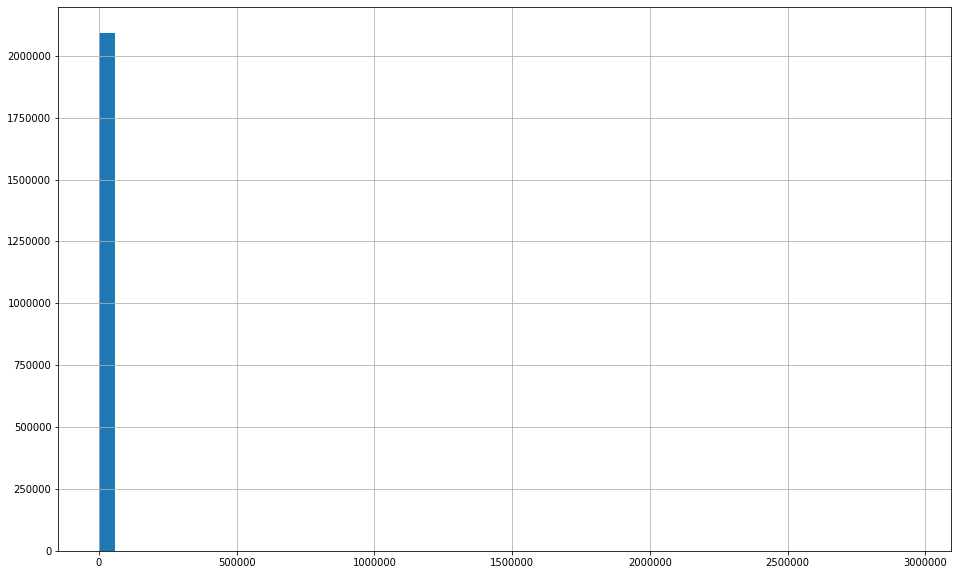

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

data_sample['tripduration'].hist(bins=50, figsize=(16,10))
plt.show()

Most of the values do not exceed one good (86400 seconds). However, there are extremely large observations

In [40]:
data_sample[['tripduration']].sort_values(by='tripduration', ascending=False)[:20]

,tripduration
42479,2946638
132013,2616700
383859,2493265
300921,2417904
86193,2055354
466589,1962511
605076,1962000
62979,1948100
825692,1790337
691709,1710328


The longest journey lasted over a month! ($2946638 \ sec \approx 34 \ days$). This may mean that the bike has not been parked properly or there is an error in the time registration system. In any case, such observations obscure the overall distribution of this feature.

In order to illustrate the distribution of travel time without taking into account outliers, it is possible to use the logarithm of a given feature

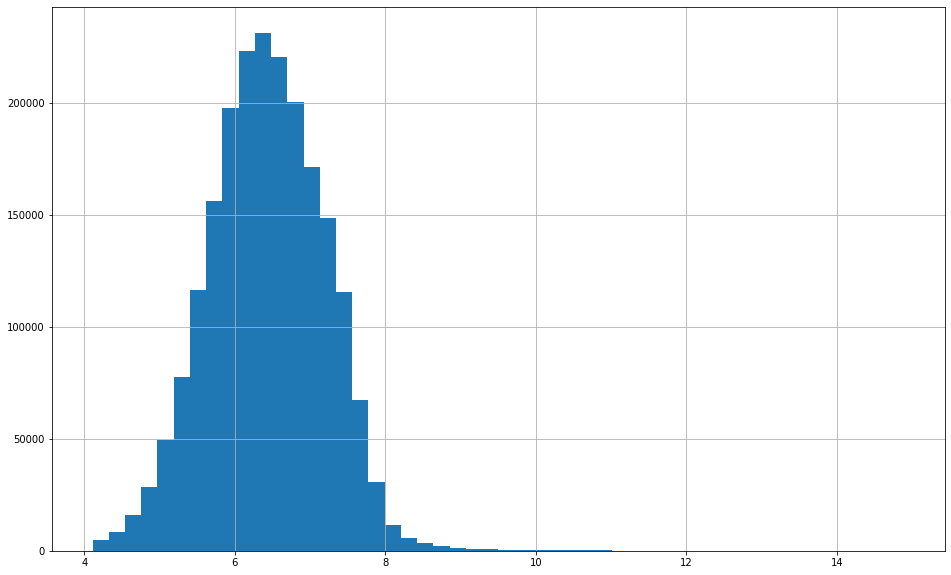

In [41]:
import numpy as np

np.log(data_sample['tripduration']).hist(bins=50, figsize=(16,10))
plt.show()

For latitude and longitude, let's first note that the station name is clearly associated with its latitude, longitude and ID. Additionaly, end locations contain more unique names - let's see first that they contain all start locations

In [49]:
set(data_sample['end station id'].unique()).issubset(set(data_sample['end station id'].unique()))

True

In [54]:
data_sample[['end station id', 'end station name', 'end station latitude', 'end station longitude']].drop_duplicates()

,end station id,end station name,end station latitude,end station longitude
0,223,W 13 St & 7 Ave,40.737815,-73.999947
1,3283,W 89 St & Columbus Ave,40.788221,-73.970416
2,174,E 25 St & 1 Ave,40.738177,-73.977387
3,477,W 41 St & 8 Ave,40.756405,-73.990026
7,3592,Crescent St & Broadway,40.763359,-73.928647
...,...,...,...,...
1958781,3827,Halsey St & Broadway,40.685650,-73.915640
1960912,3890,Grove St & Broadway,40.690470,-73.923511
2043185,3828,Eldert St & Bushwick Ave,40.686520,-73.913210
2081854,3868,Knickerbocker Ave & Halsey St,40.693000,-73.908240


Therefore, we can significantly reduce the amount of space needed in the memory by building a dictionary - its key will be the station identifier, and the value will be another dictionary that will store information about the station name and its geographical location

In [77]:
dict_data = data_sample[['end station id','end station name','end station latitude','end station longitude']].drop_duplicates()
dict_data.set_index('end station id', drop=True, inplace=True)
data_sample_station_dict = dict_data.to_dict(orient='index')
data_sample_station_dict[3833]

{'end station name': 'Madison St & Evergreen Ave',
 'end station latitude': 40.69122,
 'end station longitude': -73.91693000000001}

Geographic data is conveniently illustrated spatially

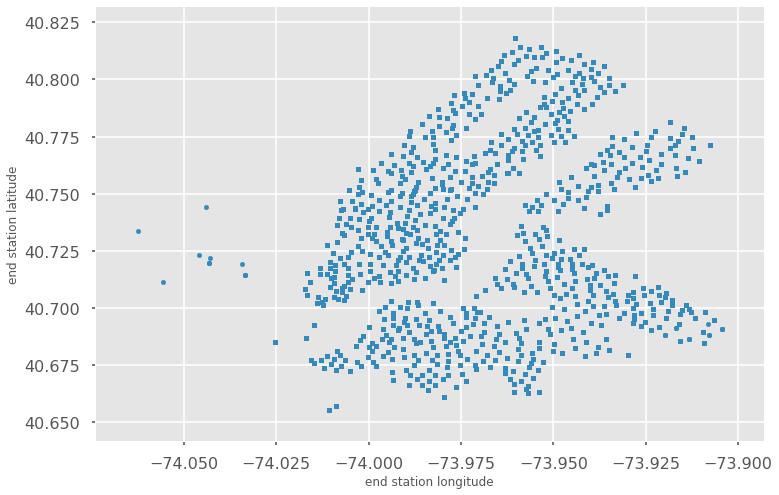

In [126]:
import matplotlib.style as style
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')

data_sample.plot(kind='scatter', x='end station longitude', y='end station latitude', alpha=1, figsize=(12,8))

The frequency of visits to a given station can be visualized by the appropriate marker shade

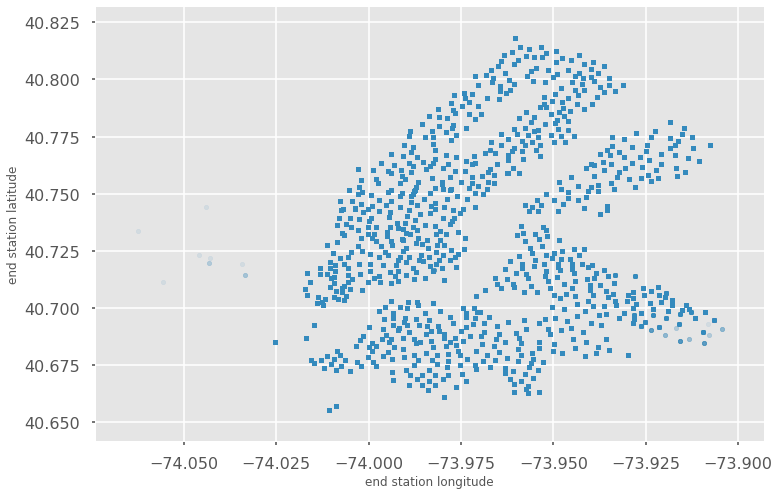

In [127]:
data_sample.plot(kind='scatter', x='end station longitude', y='end station latitude', alpha=0.1, figsize=(12,8))

Clustered stations are definitely more frequently visited than those at the ends

Interesting information that we can get from these is the frequency of visiting the station - both as the starting and ending point of the journey

In [128]:
data_sample['end_station'] = data_sample['end station id']
data_sample['end_station'].groupby(data_sample['end station id']).transform(len)

data_sample['start_station'] = data_sample['start station id']
data_sample['start_station'].groupby(data_sample['start station id']).transform(len)

data_sample.head(10)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,end_station,start_station
0,527,2019-10-01 00:00:05.618,2019-10-01 00:08:52.943,3746,6 Ave & Broome St,40.724308,-74.004730,223,W 13 St & 7 Ave,40.737815,-73.999947,41750,Subscriber,1993,1,223,3746
1,174,2019-10-01 00:00:15.875,2019-10-01 00:03:10.168,3301,Columbus Ave & W 95 St,40.791956,-73.968087,3283,W 89 St & Columbus Ave,40.788221,-73.970416,18264,Subscriber,1992,1,3283,3301
2,759,2019-10-01 00:00:19.824,2019-10-01 00:12:59.707,161,LaGuardia Pl & W 3 St,40.729170,-73.998102,174,E 25 St & 1 Ave,40.738177,-73.977387,25525,Subscriber,1995,1,174,161
3,615,2019-10-01 00:00:21.068,2019-10-01 00:10:36.679,254,W 11 St & 6 Ave,40.735324,-73.998004,477,W 41 St & 8 Ave,40.756405,-73.990026,30186,Subscriber,1992,1,477,254
4,761,2019-10-01 00:00:26.380,2019-10-01 00:13:08.313,161,LaGuardia Pl & W 3 St,40.729170,-73.998102,174,E 25 St & 1 Ave,40.738177,-73.977387,25597,Subscriber,1992,1,174,161
5,750,2019-10-01 00:00:37.906,2019-10-01 00:13:08.413,161,LaGuardia Pl & W 3 St,40.729170,-73.998102,174,E 25 St & 1 Ave,40.738177,-73.977387,21757,Subscriber,1995,1,174,161
6,454,2019-10-01 00:01:18.448,2019-10-01 00:08:52.817,525,W 34 St & 11 Ave,40.755942,-74.002116,477,W 41 St & 8 Ave,40.756405,-73.990026,41079,Subscriber,1994,1,477,525
7,416,2019-10-01 00:01:21.455,2019-10-01 00:08:17.742,3616,Steinway St & 28 Ave,40.765625,-73.913669,3592,Crescent St & Broadway,40.763359,-73.928647,33413,Subscriber,1988,1,3592,3616
8,118,2019-10-01 00:02:00.775,2019-10-01 00:03:59.561,3306,10 St & 7 Ave,40.666208,-73.981999,3310,14 St & 7 Ave,40.663779,-73.983968,38925,Subscriber,1976,1,3310,3306
9,1301,2019-10-01 00:02:06.301,2019-10-01 00:23:47.946,3687,E 33 St & 1 Ave,40.743227,-73.974498,259,South St & Whitehall St,40.701221,-74.012342,41376,Subscriber,1963,1,259,3687


Let's see which stations are the most common destinations

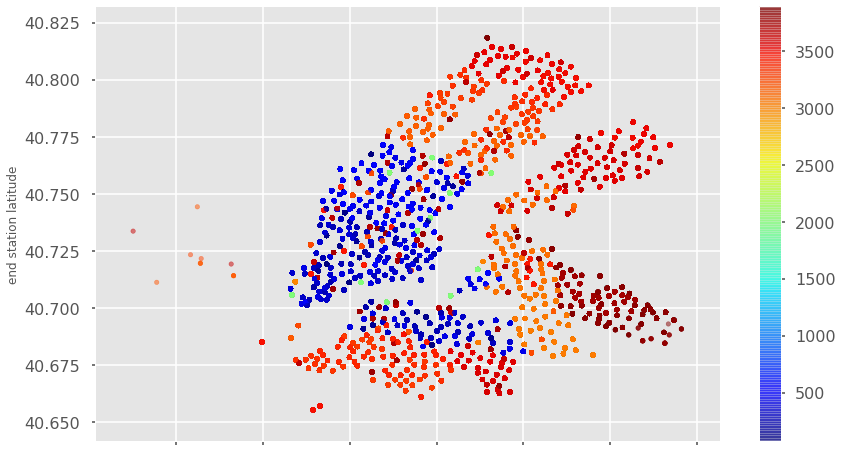

In [129]:
data_sample.plot(kind='scatter', x='end station longitude', y='end station latitude', alpha=0.5, 
                 c=data_sample['end_station'], figsize=(14,8), cmap=plt.get_cmap('jet'), colorbar=True)

An analogous graph for the starting places

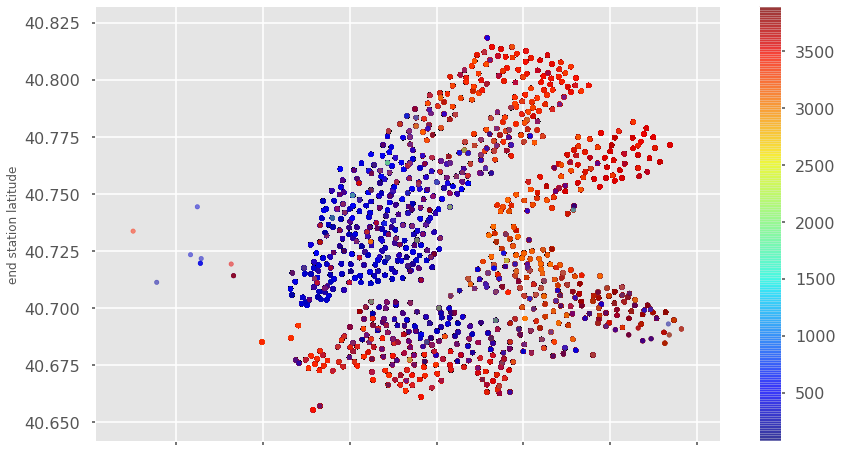

In [130]:
data_sample.plot(kind='scatter', x='end station longitude', y='end station latitude', alpha=0.5, 
                 c=data_sample['start_station'], figsize=(14,8), cmap=plt.get_cmap('jet'), colorbar=True)

On the example of the analyzed month, it can be seen that stations in the central part are much less frequently visited than others